<a href="https://colab.research.google.com/github/eathon/DeepLearningwithPython/blob/master/7_1_Keras_functional_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Companion Notebook - 7.1 Keras Functional API
## Chap 7 «Advanced Deep-learning best practices»
## «Deep Learning with Python» book by François Chollet

This notebook contains the code samples found in Chapter 7 of «Deep Learning with Python». Note that the original text features far more content, in particular further explanations and figures. 

修改與補充Claude COULOMBE的github :https://github.com/ClaudeCoulombe/deep-learning-with-python-notebooks (by Claude COULOMBE - PhD candidate - TÉLUQ / UQAM - Montréal.)

In [0]:
# sudo pip3 install --ignore-installed --upgrade tensorflow
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
KTF.set_session(session)
import keras
print(keras.__version__)
print(tf.__version__)
# To ignore keep_dims warning
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


2.2.4
1.12.0


In [0]:
!pip install graphviz 
!apt-get install graphviz 
# Install pydot to visualize the network structure
!pip install pydot
!pip install pydot-ng

#After fininishing the installation, you have to restart the colab runtime!!

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 30 newly installed, 0 to remove and 5 not upgraded.
Need to get 4,154 kB of

## 7.1 Going beyond the Sequential model: the Keras functional API

Until now, we've seen neural networks implemented using the Sequential model which makes the assumption that the network has exactly one input and one output, and that consists of a linear stack of layers.

Some networks require several independent inputs, others require multiple outputs, and networks have internal branching between layers that makes them look like graphs of layers like in the Inception and ResNET architectures.

## 7.1.1. Introduction to the Keras functional API

Fortunately there’s a more general and flexible way to use Keras: the functional API. In the functional API, you directly manipulate tensors, and you use layers as functions that take tensors and return tensors (hence, the name functional API):

In [0]:
from keras import Input, layers 
input_tensor = Input(shape=(32,))
dense = layers.Dense(32, activation='relu')
output_tensor = dense(input_tensor)

Let’s start with a minimal example that shows side by side a simple Sequential model and its equivalent in the functional API:

In [0]:
from keras.models import Sequential, Model 
from keras import layers 
from keras import Input 

seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,))) 
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))

input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = Model(input_tensor, output_tensor)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


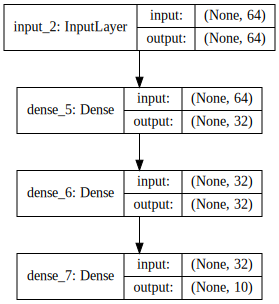

In [0]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

The only part that may seem a bit magical at this point is instantiating a Model object using only an input tensor and an output tensor. Behind the scenes, Keras retrieves every layer involved in going from input_tensor to output_tensor, bringing them together into a graph-like data structure—a Model. Of course, the reason it works is that output_tensor was obtained by repeatedly transforming input_tensor. If you tried to build a model from inputs and outputs that weren’t related, you’d get a RuntimeError:

In [0]:
unrelated_input = Input(shape=(32,))
bad_model = Model(unrelated_input, output_tensor)

This error tells you, in essence, that Keras couldn’t reach input_2 from the provided output tensor. 

When it comes to compiling, training, or evaluating such an instance of Model, the API is the same as that of Sequential:

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

import numpy as np
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10)) 

model.fit(x_train, y_train, epochs=10, batch_size=128)

score = model.evaluate(x_train, y_train)

### 7.1.2 Multi-input models

The functional API can be used to build models that have multiple inputs. Typically, such models at some point merge their different input branches using a layer that can combine several tensors: by adding them, concatenating them, and so on. This is usually done via a Keras merge operation such as keras.layers.add, keras.layers.concatenate, and so on. 

#### A question-answering model example
Let’s look at a very simple example of a multi-input model: a question-answering model. A typical question-answering model has two inputs: a natural-language question and a text snippet (such as a news article) providing information to be used for answering the question. The model must then produce an answer: in the simplest possible setup, this is a one-word answer obtained via a softmax over some predefined vocabulary (see figure 7.6).

Following is an example of how you can build such a model with the functional API. You set up two independent branches, encoding the text input and the question input as representation vectors; then, concatenate these vectors; and finally, add a softmax classifier on top of the concatenated representations.

#### Functional API implementation of a two-input question-answering model

In [0]:
from keras.models import Model
from keras import layers
from keras import Input

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# The text input is a variable-length sequence of integers. 
# Note that you can optionally name the inputs.
text_input = Input(shape=(None,), dtype='int32', name='text')
# Embeds the inputs into a sequence of vectors of size 64
# embedded_text = layers.Embedding(64, text_vocabulary_size)(text_input)
# embedded_text = layers.Embedding(output_dim=64, input_dim=text_vocabulary_size)(text_input)
embedded_text = layers.Embedding(text_vocabulary_size,64)(text_input)
# Encodes the vectors in a single vector via an LSTM
encoded_text = layers.LSTM(32)(embedded_text)
# Same process (with different layer instances) for the question
question_input = Input(shape=(None,),dtype='int32',name='question')
# embedded_question = layers.Embedding(32, question_vocabulary_size)(question_input)
# embedded_question = layers.Embedding(output_dim=32, input_dim=question_vocabulary_size)(question_input)
embedded_question = layers.Embedding(question_vocabulary_size,32)(question_input)
encoded_question = layers.LSTM(16)(embedded_question) 
# Concatenates the encoded question and encoded text
concatenated = layers.concatenate([encoded_text, encoded_question],axis=-1)
# Adds a softmax classifier on top
answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)
# At model instantiation, you specify the two inputs and the output.
model = Model([text_input, question_input], answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 64)     640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 32)     320000      question[0][0]                   
__________________________________________________________________________________________________
lstm_5 (LS

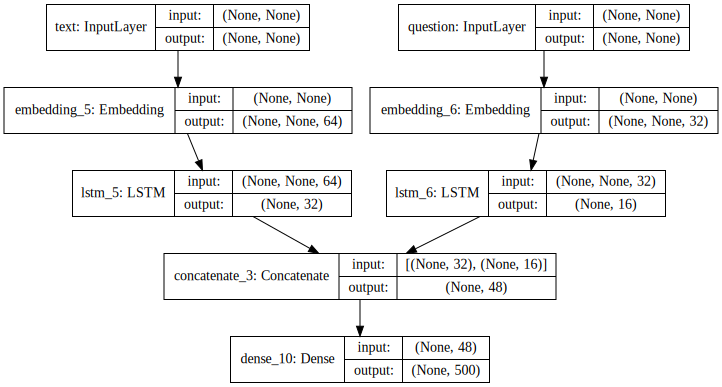

In [0]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

Now, how do you train this two-input model? There are two possible APIs: you can feed the model a list of Numpy arrays as inputs, or you can feed it a dictionary that maps input names to Numpy arrays. Naturally, the latter option is available only if you give names to your inputs. 

#### Training the multi-input model

In [0]:
import numpy as np
num_samples = 1000 
max_length = 100

# Generates dummy Numpy data
text = np.random.randint(1, text_vocabulary_size,size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size,size=(num_samples, max_length)) 
# Answers are one-hot encoded, not integers
# answers = np.random.randint(0, 1,size=(num_samples, answer_vocabulary_size))
answers = np.random.randint(answer_vocabulary_size, size=(num_samples))
answers = keras.utils.to_categorical(answers, answer_vocabulary_size)

# Fitting using a list of inputs
print('-'*10,"First training run with list of NumPy arrays",'-'*60)
model.fit([text, question], answers, epochs = 100, batch_size = 128, validation_split = 0.2)
print()

# Fitting using a dictionary of inputs (only if inputs are named)
print('-'*10,"Second training run with dictionary and named inputs",'-'*60)
model.fit({'text': text, 'question': question}, answers, epochs = 50, batch_size = 128, validation_split = 0.2)

---------- First training run with list of NumPy arrays ------------------------------------------------------------
Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 5s 6ms/step - loss: 6.2147 - acc: 0.0000e+00 - val_loss: 6.2158 - val_acc: 0.0000e+00
Epoch 2/100
800/800 [==============================] - 3s 4ms/step - loss: 6.1995 - acc: 0.0488 - val_loss: 6.2169 - val_acc: 0.0000e+00
Epoch 3/100
800/800 [==============================] - 3s 4ms/step - loss: 6.1778 - acc: 0.0262 - val_loss: 6.2355 - val_acc: 0.0000e+00
Epoch 4/100
800/800 [==============================] - 3s 4ms/step - loss: 6.0905 - acc: 0.0050 - val_loss: 6.2820 - val_acc: 0.0000e+00
Epoch 5/100
800/800 [==============================] - 3s 4ms/step - loss: 6.0024 - acc: 0.0063 - val_loss: 6.3456 - val_acc: 0.0000e+00
Epoch 6/100
800/800 [==============================] - 3s 4ms/step - loss: 5.9337 - acc: 0.0100 - val_loss: 6.3444 - val_acc: 0.0000e+00
Epoch 7/100

#### 使用真實文本資料 -Training the multi-input model

在使用模擬資料後, 來試試真實的文字資料吧! 

1.   Facebook, The (20) QA bAbI tasks


> Sngle supporting fact (task #1)








In [0]:
#先下載文本資料
!wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz
!tar -xvzf tasks_1-20_v1-2.tar.gz

#安裝自然語言處理的套件
!pip install -q nltk 
import nltk
#安裝nltk所需的
nltk.download('punkt')

--2018-11-15 14:29:45--  http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz
Resolving www.thespermwhale.com (www.thespermwhale.com)... 69.65.3.210
Connecting to www.thespermwhale.com (www.thespermwhale.com)|69.65.3.210|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15719851 (15M) [application/x-gzip]
Saving to: ‘tasks_1-20_v1-2.tar.gz.1’

tasks_1-20_v1-2.tar 100%[===================>]  14.99M  7.11MB/s    in 2.1s    

2018-11-15 14:29:48 (7.11 MB/s) - ‘tasks_1-20_v1-2.tar.gz.1’ saved [15719851/15719851]

tasks_1-20_v1-2/
tasks_1-20_v1-2/hn/
tasks_1-20_v1-2/hn/qa16_basic-induction_train.txt
tasks_1-20_v1-2/hn/qa13_compound-coreference_train.txt
tasks_1-20_v1-2/hn/qa13_compound-coreference_test.txt
tasks_1-20_v1-2/hn/qa14_time-reasoning_test.txt
tasks_1-20_v1-2/hn/qa5_three-arg-relations_test.txt
tasks_1-20_v1-2/hn/qa17_positional-reasoning_train.txt
tasks_1-20_v1-2/hn/qa9_simple-negation_train.txt
tasks_1-20_v1-2/hn/qa12_conjunction_train.txt
t

True

In [0]:
#資料前處理所需的function

from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import collections
import itertools
import nltk
import numpy as np
import os

def get_data(infile):
    stories, questions, answers = [], [], []
    story_text = []
    fin = open(TRAIN_FILE, "rb")
    for line in fin:
        line = line.decode("utf-8").strip()
        lno, text = line.split(" ", 1)
        if "\t" in text:
            question, answer, _ = text.split("\t")
            stories.append(story_text)
            questions.append(question)
            answers.append(answer)
            story_text = []
        else:
            story_text.append(text)
    fin.close()
    return stories, questions, answers


def build_vocab(train_data, test_data):
    counter = collections.Counter()
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            for sent in story:
                for word in nltk.word_tokenize(sent):
                    counter[word.lower()] += 1
        for question in questions:
            for word in nltk.word_tokenize(question):
                counter[word.lower()] += 1
        for answer in answers:
            for word in nltk.word_tokenize(answer):
                counter[word.lower()] += 1
    # no OOV here because there are not too many words in dataset
    word2idx = {w: (i+1) for i, (w, _) in enumerate(counter.most_common())}
    word2idx["PAD"] = 0
    idx2word = {v: k for k, v in word2idx.items()}
    return word2idx, idx2word


def get_maxlens(train_data, test_data):
    story_maxlen, question_maxlen = 0, 0
    for stories, questions, _ in [train_data, test_data]:
        for story in stories:
            story_len = 0
            for sent in story:
                swords = nltk.word_tokenize(sent)
                story_len += len(swords)
            if story_len > story_maxlen:
                story_maxlen = story_len
        for question in questions:
            question_len = len(nltk.word_tokenize(question))
            if question_len > question_maxlen:
                question_maxlen = question_len
    return story_maxlen, question_maxlen


def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        print ('Story:',story)
        print ('Question:',question)
        print ('Answer:',answer)
        xs = [[word2idx[w.lower()] for w in nltk.word_tokenize(s)]
              for s in story]
        xs = list(itertools.chain.from_iterable(xs))
        xq = [word2idx[w.lower()] for w in nltk.word_tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer.lower()])
        pad_sequences_Xs = pad_sequences(Xs, maxlen=story_maxlen)
        pad_sequences_Xq = pad_sequences(Xq, maxlen=question_maxlen)
        categorical_Y = np_utils.to_categorical(Y, num_classes=len(word2idx))

    return pad_sequences_Xs, pad_sequences_Xq, categorical_Y
  
  
  
# Tensorboard

#安裝tensorboard colab
!pip install tensorboardcolab
from __future__ import absolute_import
from __future__ import unicode_literals
from time import gmtime, strftime
from keras.callbacks import TensorBoard
from tensorboardcolab import *


import os


def make_tensorboard(set_dir_name=''):
    tictoc = strftime("%a_%d_%b_%Y_%H_%M_%S", gmtime())
    directory_name = tictoc
    log_dir = set_dir_name + '_' + directory_name
    os.mkdir(log_dir)
    tbc=TensorBoardColab()
    #tensorboard = TensorBoard(log_dir=log_dir)
    tensorboard = TensorBoardColabCallback(tbc,histogram_freq=1,embeddings_freq=1,  embeddings_layer_names = ['embedded_text','embedded_question'], embeddings_data = [Xstrain, Xqtrain] ) #, embeddings_metadata = '/content/logs/' + meta_file
    # ['embedded_text','embedded_question']
    return tensorboard

In [0]:

DATA_DIR = "tasks_1-20_v1-2/en"

TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test.txt")

# get the data
data_train = get_data(TRAIN_FILE)
data_test = get_data(TEST_FILE)

print(len(data_train[0]), len(data_test[0]))

# build vocabulary from all the data
word2idx, idx2word = build_vocab(data_train, data_test)

vocab_size = len(word2idx)
print("vocab size: {:d}".format(len(word2idx)))

# compute max sequence length for each entity
story_maxlen, question_maxlen = get_maxlens(data_train, data_test)
print("story maxlen: {:d}, "
      "question maxlen: {:d}".format(story_maxlen, question_maxlen))

meta_file = "w2v_metadata.tsv"
# 按照 id 排序
word2idx_sorted = [(k, word2idx[k]) for k in sorted(word2idx, key = word2idx.get, reverse = False)]



1000 1000
vocab size: 22
story maxlen: 14, question maxlen: 4


In [0]:
word2idx_sorted

[('PAD', 0),
 ('to', 1),
 ('the', 2),
 ('.', 3),
 ('where', 4),
 ('is', 5),
 ('?', 6),
 ('went', 7),
 ('sandra', 8),
 ('john', 9),
 ('daniel', 10),
 ('mary', 11),
 ('hallway', 12),
 ('kitchen', 13),
 ('garden', 14),
 ('office', 15),
 ('bedroom', 16),
 ('bathroom', 17),
 ('journeyed', 18),
 ('travelled', 19),
 ('moved', 20),
 ('back', 21)]

In [0]:
# vectorize the data
Xstrain, Xqtrain, Ytrain = \
    vectorize(data_train, word2idx, story_maxlen, question_maxlen)
Xstest, Xqtest, Ytest = \
    vectorize(data_test, word2idx, story_maxlen, question_maxlen)

print(Xstrain.shape, Xqtrain.shape, Ytrain.shape,
      Xstest.shape, Xqtest.shape, Ytest.shape)


Story: ['Mary moved to the bathroom.', 'John went to the hallway.']
Question: Where is Mary? 
Answer: bathroom
Story: ['Daniel went back to the hallway.', 'Sandra moved to the garden.']
Question: Where is Daniel? 
Answer: hallway
Story: ['John moved to the office.', 'Sandra journeyed to the bathroom.']
Question: Where is Daniel? 
Answer: hallway
Story: ['Mary moved to the hallway.', 'Daniel travelled to the office.']
Question: Where is Daniel? 
Answer: office
Story: ['John went back to the garden.', 'John moved to the bedroom.']
Question: Where is Sandra? 
Answer: bathroom
Story: ['Sandra travelled to the office.', 'Sandra went to the bathroom.']
Question: Where is Sandra? 
Answer: bathroom
Story: ['Mary went to the bedroom.', 'Daniel moved to the hallway.']
Question: Where is Sandra? 
Answer: bathroom
Story: ['John went to the garden.', 'John travelled to the office.']
Question: Where is Sandra? 
Answer: bathroom
Story: ['Daniel journeyed to the bedroom.', 'Daniel travelled to the hal

In [0]:
from os.path import exists, join
from os import makedirs
import keras.backend as K
K.clear_session()
# define network
EMBEDDING_SIZE = 64

BATCH_SIZE = 32
NUM_EPOCHS = 400
log_dir = './logs'
if not exists(log_dir):
    makedirs(log_dir)
    

meta_file = "w2v_metadata.tsv"    
with open(os.path.join(log_dir, meta_file), 'w+') as file_metadata:
    for word in word2idx_sorted:
        if word[0] == '':
            print("Emply Line, should replecaed by any thing else, or will cause a bug of tensorboard")
            file_metadata.write('<Empty Line>' + '\n')
        else:
            file_metadata.write(word[0] + '\n')

# inputs
story_input = Input(shape=(story_maxlen,), name='text')
question_input = Input(shape=(question_maxlen,), name='question')



embedded_text = layers.Embedding(input_dim=vocab_size,
                          output_dim=EMBEDDING_SIZE,
                          input_length=story_maxlen, name='embedded_text')(story_input)
#embedded_text = Dropout(0.3)(embedded_text)


encoded_text = layers.LSTM(32)(embedded_text)



#question_input = Input(shape=(None,),dtype='int32', name='question')
embedded_question = layers.Embedding(input_dim=vocab_size,
                             output_dim=EMBEDDING_SIZE,
                             input_length=question_maxlen, name='embedded_question')(question_input)
#embedded_question = Dropout(0.3)(embedded_question)

encoded_question = layers.LSTM(16)(embedded_question)


concatenated = layers.concatenate([encoded_text, encoded_question],axis=-1)
answer = layers.Dense(vocab_size,
activation='softmax')(concatenated)

model = Model([story_input, question_input], answer)
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['acc'])
                         

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 14)           0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
embedded_text (Embedding)       (None, 14, 64)       1408        text[0][0]                       
__________________________________________________________________________________________________
embedded_question (Embedding)   (None, 4, 64)        1408        question[0][0]                   
__________________________________________________________________________________________________
lstm_1 (LS

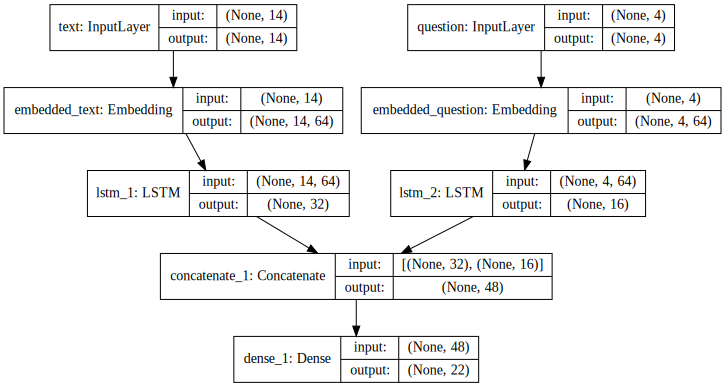

In [0]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


In [0]:
from keras.utils import plot_model
plot_model(model, to_file='qa_model.png')
from google.colab import files
files.download('qa_model.png')

In [0]:
Xstrain[0]

array([ 0,  0, 11, 20,  1,  2, 17,  3,  9,  7,  1,  2, 12,  3],
      dtype=int32)

In [0]:
Xqtrain.shape

(1000, 4)

In [0]:
Xstrain.shape

(1000, 14)

In [0]:
for layer in model.layers:
  print (layer.name)
  if layer.name =='embedded_text':
    embedding_input = model.get_layer(layer.name).output
    print (embedding_input.shape[1:])
    embedding_size = np.prod(embedding_input.shape[1:])
    print (embedding_size)
  

text
question
embedded_text
(14, 64)
896
embedded_question
lstm_1
lstm_2
concatenate_1
dense_1


In [0]:
#啟動Tensobard
from keras import backend as K


tensorboard = make_tensorboard(set_dir_name='mem-network')

#開始訓練模型
history = model.fit([Xstrain, Xqtrain], [Ytrain], batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    callbacks=[tensorboard],
                    validation_data=([Xstest, Xqtest], [Ytest]))

Wait for 8 seconds...
TensorBoard link:
http://8882a16a.ngrok.io
Train on 1000 samples, validate on 1000 samples
Epoch 1/400
1000/1000 [==============================] - 4s 4ms/step - loss: 2.4402 - acc: 0.1660 - val_loss: 1.9202 - val_acc: 0.1660
Epoch 2/400
1000/1000 [==============================] - 2s 2ms/step - loss: 1.8571 - acc: 0.1780 - val_loss: 1.8116 - val_acc: 0.1730
Epoch 3/400
1000/1000 [==============================] - 2s 2ms/step - loss: 1.8007 - acc: 0.1890 - val_loss: 1.7768 - val_acc: 0.2610
Epoch 4/400
1000/1000 [==============================] - 2s 2ms/step - loss: 1.7562 - acc: 0.2650 - val_loss: 1.7292 - val_acc: 0.3040
Epoch 5/400
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6956 - acc: 0.3290 - val_loss: 1.6507 - val_acc: 0.3390
Epoch 6/400
1000/1000 [==============================] - 2s 2ms/step - loss: 1.6333 - acc: 0.3710 - val_loss: 1.6238 - val_acc: 0.3610
Epoch 7/400
1000/1000 [==============================] - 2s 2ms/step - loss: 

In [0]:
#針對測試集進行模型的測試

ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

NUM_DISPLAY = 10

for i in range(NUM_DISPLAY):
    story = " ".join([idx2word[x] for x in Xstest[i].tolist() if x != 0])
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print(story, question, label, prediction)

mary moved to the bathroom . john went to the hallway . where is mary ? bathroom bathroom
daniel went back to the hallway . sandra moved to the garden . where is daniel ? hallway hallway
john moved to the office . sandra journeyed to the bathroom . where is daniel ? hallway hallway
mary moved to the hallway . daniel travelled to the office . where is daniel ? office office
john went back to the garden . john moved to the bedroom . where is sandra ? bathroom bathroom
sandra travelled to the office . sandra went to the bathroom . where is sandra ? bathroom bathroom
mary went to the bedroom . daniel moved to the hallway . where is sandra ? bathroom bathroom
john went to the garden . john travelled to the office . where is sandra ? bathroom bathroom
daniel journeyed to the bedroom . daniel travelled to the hallway . where is john ? office office
john went to the bedroom . john travelled to the office . where is daniel ? hallway office


In [0]:
#儲存訓練好的模型
import h5py
model.save('qa_model.h5')

In [0]:
from keras.models import load_model
my_model = load_model('qa_model.h5')

ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = my_model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

NUM_DISPLAY = 10

for i in range(NUM_DISPLAY):
    story = " ".join([idx2word[x] for x in Xstest[i].tolist() if x != 0])
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print(story, question, label, prediction)

mary moved to the bathroom . john went to the hallway . where is mary ? bathroom bathroom
daniel went back to the hallway . sandra moved to the garden . where is daniel ? hallway hallway
john moved to the office . sandra journeyed to the bathroom . where is daniel ? hallway hallway
mary moved to the hallway . daniel travelled to the office . where is daniel ? office office
john went back to the garden . john moved to the bedroom . where is sandra ? bathroom bathroom
sandra travelled to the office . sandra went to the bathroom . where is sandra ? bathroom bathroom
mary went to the bedroom . daniel moved to the hallway . where is sandra ? bathroom bathroom
john went to the garden . john travelled to the office . where is sandra ? bathroom bathroom
daniel journeyed to the bedroom . daniel travelled to the hallway . where is john ? office office
john went to the bedroom . john travelled to the office . where is daniel ? hallway office


#### **來試試加入Google word2vec的embeddings 來做模型的訓練**

In [0]:
!pip install gensim
from __future__ import division, print_function
from gensim.models import Word2Vec
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.models import Sequential
from sklearn.cross_validation import train_test_split
import numpy as np
from gensim.models import KeyedVectors
import os



#下載Google word embeedings
!wget --no-check-certificate -r 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz' -O GoogleNews-vectors-negative300.bin.gz


#https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
WORD2VEC_BIN = "GoogleNews-vectors-negative300.bin.gz"

#設定資料(word2vec)存放目錄
DATA_DIR  = "./"

word2vec = KeyedVectors.load_word2vec_format(
    os.path.join(DATA_DIR, WORD2VEC_BIN), binary=True)


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


will be placed in the single file you specified.

--2018-11-15 06:38:01--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.158
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  77.3MB/s    in 20s     

2018-11-15 06:38:21 (76.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]

FINISHED --2018-11-15 06:38:21--
Total wall clock time: 21s
Downloaded: 1 files, 1.5G in 20s (76.7 MB/s)


In [0]:
WORD2VEC_EMBED_SIZE = 300
embedding_weights = np.zeros((vocab_size, WORD2VEC_EMBED_SIZE))
for word, index in word2idx.items():
    try:
        embedding_weights[index, :] = word2vec[word.lower()]
    except KeyError:
        pass  # keep as zero (not ideal, but what else can we do?)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
story (InputLayer)              (None, 14)           0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 14, 300)      6600        story[0][0]                      
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 4, 300)       6600        question[0][0]                   
__________________________________________________________________________________________________
lstm_1 (LS

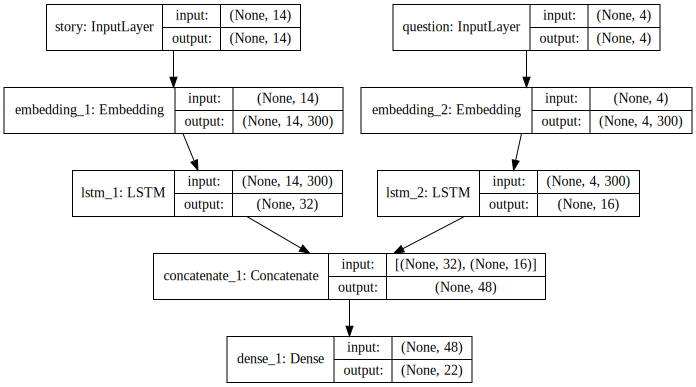

In [0]:
from keras.layers import Dense, Dropout, Reshape, Flatten
import keras.backend as K
K.clear_session()
# define network
EMBEDDING_SIZE = 300
LATENT_SIZE = 32
BATCH_SIZE = 32
NUM_EPOCHS = 400

# inputs
story_input = Input(shape=(story_maxlen,), name ='story')
question_input = Input(shape=(question_maxlen,), name ='question')


#text_input = Input(shape=(None,), dtype='int32', name='text')
embedded_text = layers.Embedding(input_dim=vocab_size,
                          output_dim=EMBEDDING_SIZE,
                          input_length=story_maxlen, weights=[embedding_weights], trainable=False)(story_input)
#embedded_text = Dropout(0.3)(embedded_text)


encoded_text = layers.LSTM(32)(embedded_text)



#question_input = Input(shape=(None,),dtype='int32', name='question')
embedded_question = layers.Embedding(input_dim=vocab_size,
                             output_dim=EMBEDDING_SIZE,
                             input_length=question_maxlen, weights=[embedding_weights],  trainable=False)(question_input)
#embedded_question = Dropout(0.3)(embedded_question)

encoded_question = layers.LSTM(16)(embedded_question)

#Merge([qenc, aenc], mode="dot", dot_axes=[1, 1])
concatenated = layers.concatenate([encoded_text, encoded_question],axis=-1)
answer = layers.Dense(vocab_size,
activation='softmax')(concatenated)
model = Model([story_input, question_input], answer)
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['acc'])
model.summary()
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
def make_tensorboard(set_dir_name=''):
    tictoc = strftime("%a_%d_%b_%Y_%H_%M_%S", gmtime())
    directory_name = tictoc
    log_dir = set_dir_name + '_' + directory_name
    os.mkdir(log_dir)
    tbc=TensorBoardColab()
    #tensorboard = TensorBoard(log_dir=log_dir)
    tensorboard = TensorBoardColabCallback(tbc,histogram_freq=1,embeddings_freq=0,  embeddings_layer_names = ['embedded_text','embedded_question'] ) #, embeddings_metadata = '/content/logs/' + meta_file
    # ['embedded_text','embedded_question']
    return tensorboard

In [0]:
tensorboard = make_tensorboard(set_dir_name='network')

#開始訓練模型
history = model.fit([Xstrain, Xqtrain], [Ytrain], batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    callbacks=[tensorboard],
                    validation_data=([Xstest, Xqtest], [Ytest]))

Wait for 8 seconds...
TensorBoard link:
http://05f9b0a2.ngrok.io
Train on 1000 samples, validate on 1000 samples
Epoch 1/400
1000/1000 [==============================] - 4s 4ms/step - loss: 2.3178 - acc: 0.2010 - val_loss: 1.8685 - val_acc: 0.3140
Epoch 2/400
1000/1000 [==============================] - 3s 3ms/step - loss: 1.7379 - acc: 0.3840 - val_loss: 1.6171 - val_acc: 0.4190
Epoch 3/400
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5276 - acc: 0.5070 - val_loss: 1.4546 - val_acc: 0.5230
Epoch 4/400
1000/1000 [==============================] - 3s 3ms/step - loss: 1.4010 - acc: 0.5500 - val_loss: 1.3965 - val_acc: 0.5120
Epoch 5/400
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3299 - acc: 0.5460 - val_loss: 1.3570 - val_acc: 0.5220
Epoch 6/400
1000/1000 [==============================] - 3s 3ms/step - loss: 1.2821 - acc: 0.5450 - val_loss: 1.2508 - val_acc: 0.5660
Epoch 7/400
1000/1000 [==============================] - 3s 3ms/step - loss: 

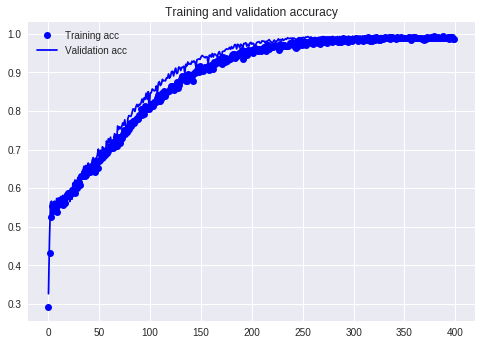

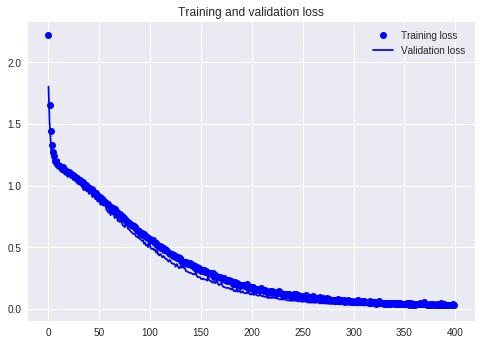

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 7.1.3 Multi-output models
You can also use the functional API to build models with multiple outputs (or multiple heads). 

####  Example - prediction of Age, Gender and Income from social media posts
A simple example is a network that attempts to simultaneously predict different properties of the data, such as a network that takes as input a series of social media posts from a single anonymous person and tries to predict attributes of that person, such as age, gender, and income level (see figure 7.7, below).

#### Functional API implementation of a three-ouputs prediction model

In [0]:
from keras import layers
from keras import Input 
from keras.models import Model 

vocabulary_size = 50000 
num_income_groups = 10 

posts_input = Input(shape=(None,), dtype='int32', name='posts')
# embedded_posts = layers.Embedding(256, vocabulary_size)(posts_input) 
embedded_posts = layers.Embedding(vocabulary_size,256)(posts_input)
x = layers.Conv1D(128, 5, activation='relu', padding='same')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x) 
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x) 

# Note that the output layers are given names.
age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups, activation='softmax',name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)
model = Model(posts_input,[age_prediction, income_prediction, gender_prediction])

print("Model is ready!")


Model is ready!


#### Why put padding='same'

https://stackoverflow.com/questions/50281564/why-i-cant-set-kernel-size-in-1d-convolution

When I run it show error like this. InvalidArgumentError: computed output size would be negative

If you use padding "same" this would just yield an output of one number (the input number multiplied by the middle number of your kernel), but with the default "valid" padding, this would make the output size negative.

Importantly, training such a model requires the ability to specify different loss functions for different heads of the network: for instance, age prediction is a scalar regression task, but gender prediction is a binary classification task, requiring a different training procedure. But because gradient descent requires you to minimize a scalar, you must combine these losses into a single value in order to train the model. The simplest way to combine different losses is to sum them all. In Keras, you can use either a list or a dictionary of losses in compile to specify different objects for different outputs; the resulting loss values are summed into a global loss, which is minimized during training.

#### Compilation options of a multi-output model: multiple losses

In [0]:
model.compile(optimizer='rmsprop', loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'])

# Equivalent (possible only if you give names to the output layers)
model.compile(optimizer='rmsprop',loss={'age': 'mse',
                                        'income': 'categorical_crossentropy',
                                        'gender': 'binary_crossentropy'})

#### Problem with imbalanced loss contributions

Note that very imbalanced loss contributions will cause the model representations to be optimized preferentially for the task with the largest individual loss, at the expense of the other tasks. To remedy this, you can assign different levels of importance to the loss values in their contribution to the final loss. This is useful in particular if the losses’ values use different scales. 

For instance, the mean squared error (MSE) loss used for the age-regression task typically takes a value around 3–5, whereas the cross-entropy loss used for the gender-classification task can be as low as 0.1. In such a situation, to balance the contribution of the different losses, you can assign a weight of 10 to the crossentropy loss and a weight of 0.25 to the MSE loss.

#### Solution to imbalanced loss contributions

In [0]:
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              loss_weights=[0.25, 1., 10.]) 

# Equivalent (possible only if you give names to the output layers)
model.compile(optimizer='rmsprop',
              loss={'age': 'mse','income': 'categorical_crossentropy','gender': 'binary_crossentropy'},
              loss_weights={'age': 0.25,
                            'income': 1.,
                            'gender': 10.})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, None, 128)    163968      embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, None, 128)    0           conv1d_6[0][0]                   
__________________________________________________________________________________________________
conv1d_7 (

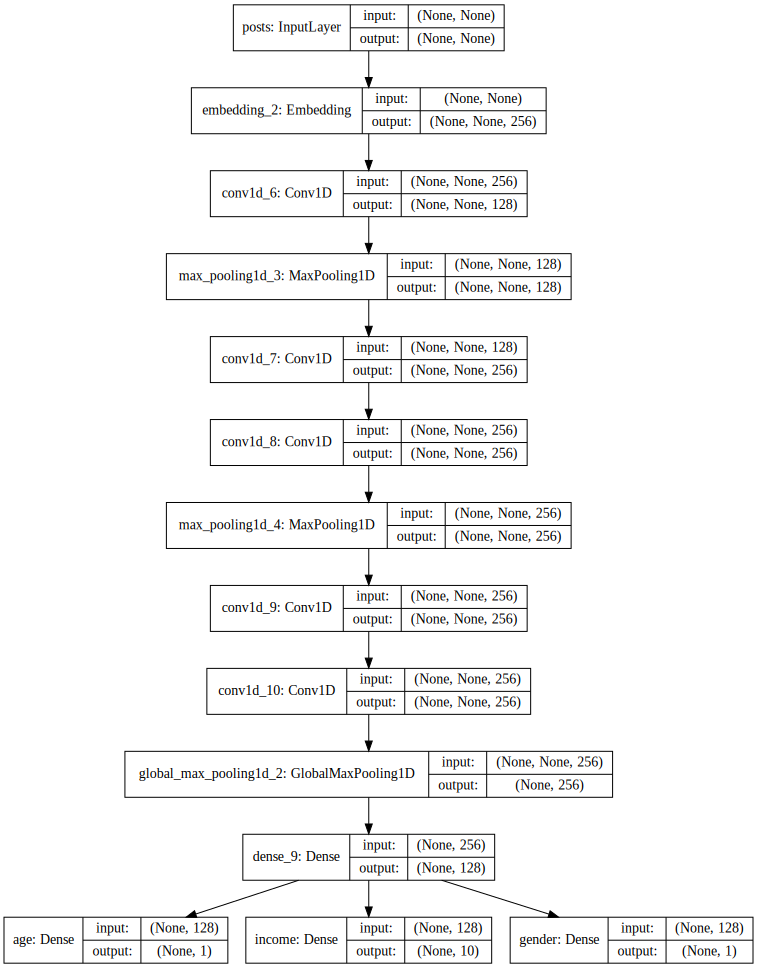

In [0]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
#下載模型的視覺化圖檔
from keras.utils import plot_model
plot_model(model, to_file='model.png')
from google.colab import files
files.download('model.png')

#### Feeding data to a multi-output model

Much as in the case of multi-input models, you can pass Numpy data to the model for training either via a list of arrays or via a dictionary of arrays.

#### Training a multi-output model

In [0]:
import numpy as np 

TRACE = False

num_samples = 1000 
max_length = 100 
#產生模擬資料，用於訓練模型
posts = np.random.randint(1, vocabulary_size, size=(num_samples, max_length))
if TRACE:
    print("*** POSTS ***")
    print(posts.shape)
    print(posts[:10])
    print()

age_targets = np.random.randint(0, 100, size=(num_samples,1))
if TRACE:
    print("*** AGE ***")
    print(age_targets.shape)
    print(age_targets[:10])
    print()

income_targets = np.random.randint(1, num_income_groups, size=(num_samples,1))
income_targets = keras.utils.to_categorical(income_targets,num_income_groups)
if TRACE:
    print("*** INCOME ***")
    print(income_targets.shape)
    print(income_targets[:10])
    print()

gender_targets = np.random.randint(0, 2, size=(num_samples,1))
if TRACE:
    print("*** GENDER ***")
    print(gender_targets.shape)
    print(gender_targets[:10])
    print()

print('-'*10, "First training run with NumPy arrays", '-'*60)
# age_targets, income_targets, and gender_targets are assumed to be Numpy arrays.
model.fit(posts, [age_targets, income_targets, gender_targets], epochs=10, batch_size=64)

print('-'*10,"Second training run with dictionary and named outputs",'-'*60)
# Equivalent (possible only if you give names to the output layers)
model.fit(posts, {'age': age_targets,
                  'income': income_targets,
                  'gender': gender_targets},
          epochs=10, batch_size=64)

---------- First training run with NumPy arrays ------------------------------------------------------------
Epoch 1/10
1000/1000 [==============================] - 11s 11ms/step - loss: 3411.8500 - age_loss: 13577.6849 - income_loss: 5.7806 - gender_loss: 1.1648
Epoch 2/10
1000/1000 [==============================] - 10s 10ms/step - loss: 149.7953 - age_loss: 554.7659 - income_loss: 3.8756 - gender_loss: 0.7228
Epoch 3/10
1000/1000 [==============================] - 9s 9ms/step - loss: 79.1326 - age_loss: 272.7328 - income_loss: 2.6991 - gender_loss: 0.8250
Epoch 4/10
1000/1000 [==============================] - 9s 9ms/step - loss: 293.9686 - age_loss: 1090.0484 - income_loss: 4.2947 - gender_loss: 1.7162
Epoch 5/10
1000/1000 [==============================] - 9s 9ms/step - loss: 183.9122 - age_loss: 612.1404 - income_loss: 5.3536 - gender_loss: 2.5523
Epoch 6/10
1000/1000 [==============================] - 9s 9ms/step - loss: 194470.8482 - age_loss: 777556.2353 - income_loss: 13.6860

### 7.1.4 Directed acyclic graphs of layers 

With the functional API, not only can you build models with multiple inputs and multiple outputs, but you can also implement networks with a complex internal topology. Neural networks in Keras are allowed to be arbitrary directed acyclic graphs of layers. The qualifier acyclic is important: these graphs can’t have cycles. It’s impossible for a tensor <strong>x</strong> to become the input of one of the layers that generated <strong>x</strong>. The only processing loops that are allowed (that is, recurrent connections) are those internal to recurrent layers. 

Several common neural-network components are implemented as graphs. Two notable ones are <i>Inception modules</i> and <i>residual connections</i>. To better understand how the functional API can be used to build graphs of layers, let’s take a look at how you can implement both of them in Keras.

#### Inception modules 

Inception [3] is a popular type of network architecture for convolutional neural networks. It consists of a stack of modules that themselves look like small independent networks, split into several parallel branches.

##### The purpose of 1 × 1 convolutions 

1 × 1 convolutions (also called pointwise convolutions) are featured in Inception modules, where they contribute to factoring out channel-wise feature learning and space-wise feature learning.
 

In [0]:
from keras import layers 
from keras.layers import Input

# This example assumes the existence of a 4D input tensor x:
# This returns a typical image tensor like those of MNIST dataset 
x = Input(shape=(28, 28, 1), dtype='float32', name='images')
print("x.shape:",x.shape)

# Every branch has the same stride value (2), which is necessary to 
# keep all branch outputs the same size so you can concatenate them
branch_a = layers.Conv2D(128, 1, padding='same', activation='relu', strides=2)(x)

# In this branch, the striding occurs in the spatial convolution layer.
branch_b = layers.Conv2D(128, 1, padding='same', activation='relu')(x)
branch_b = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_b)

# In this branch, the striding occurs in the average pooling layer.
branch_c = layers.AveragePooling2D(3,  padding='same', strides=2)(x)
branch_c = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, padding='same', activation='relu')(x) 
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_d)

# Concatenates the branch outputs to obtain the module output
output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)

# Adding a classifier on top of the convnet
output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)

model = keras.models.Model(inputs=x, outputs=predictions)

x.shape: (?, 28, 28, 1)


#### Train the Inception model using the Dataset API and the MNIST data

Inspired by: https://github.com/keras-team/keras/blob/master/examples/mnist_dataset_api.py

In [0]:
import numpy as np
import os
import tempfile

import keras
from keras import backend as K
from keras import layers
from keras.datasets import mnist

import tensorflow as tf

if K.backend() != 'tensorflow':
    raise RuntimeError('This example can only run with the TensorFlow backend,'
                       ' because it requires the Dataset API, which is not'
                       ' supported on other platforms.')

batch_size = 128
buffer_size = 10000
steps_per_epoch = int(np.ceil(60000 / float(batch_size)))  # = 469
epochs = 5
num_classes = 10

def cnn_layers(x):
    
    # This example assumes the existence of a 4D input tensor x:
    # This returns a typical image tensor like those of MNIST dataset 
    print("x.shape:",x.shape)

    # Every branch has the same stride value (2), which is necessary to 
    # keep all branch outputs the same size so you can concatenate them
    branch_a = layers.Conv2D(128, 1, padding='same', activation='relu', strides=2)(x)

    # In this branch, the striding occurs in the spatial convolution layer.
    branch_b = layers.Conv2D(128, 1, padding='same', activation='relu')(x)
    branch_b = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_b)

    # In this branch, the striding occurs in the average pooling layer.
    branch_c = layers.AveragePooling2D(3,  padding='same', strides=2)(x)
    branch_c = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_c)

    branch_d = layers.Conv2D(128, 1, padding='same', activation='relu')(x) 
    branch_d = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_d)
    branch_d = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_d)

    # Concatenates the branch outputs to obtain the module output
    output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)

    # Adding a classifier on top of the convnet
    output = layers.Flatten()(output)
    output = layers.Dense(512, activation='relu')(output)
    predictions = layers.Dense(num_classes, activation='softmax')(output)
    
    return predictions

  #使用MNIST資料集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_train = np.expand_dims(x_train, -1)
y_train = tf.one_hot(y_train, num_classes)

# Create the dataset and its associated one-shot iterator.
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size)
iterator = dataset.make_one_shot_iterator()

# Model creation using tensors from the get_next() graph node.
inputs, targets = iterator.get_next()

print("inputs.shape:",inputs.shape)
print("targets.shape:",targets.shape)

model_input = layers.Input(tensor=inputs)
model_output = cnn_layers(model_input)

model = keras.models.Model(inputs=model_input, outputs=model_output)

model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              target_tensors=[targets])

Using TensorFlow backend.


inputs.shape: (?, 28, 28, 1)
targets.shape: (?, 10)
x.shape: (?, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 128)  256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  256         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 14, 14, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (

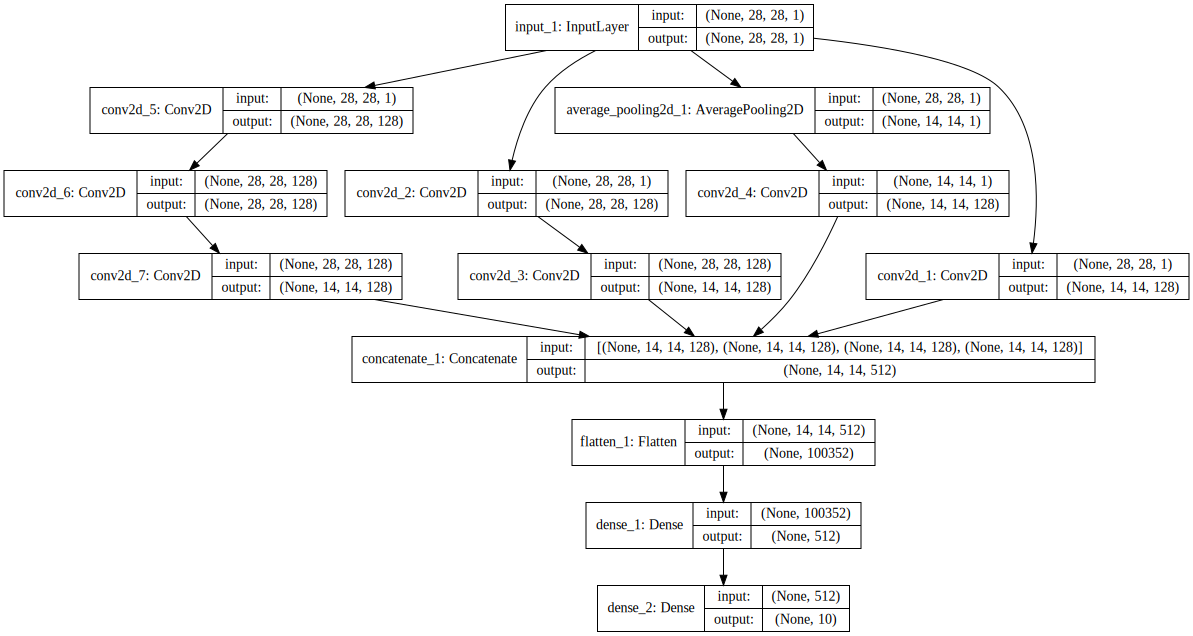

In [0]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
#下載模型的視覺化圖檔
from keras.utils import plot_model
plot_model(model, to_file='model_Inception.png')
from google.colab import files
files.download('model_Inception.png')

#### Train Inception model

In [0]:
model.fit(epochs=epochs,
          steps_per_epoch=steps_per_epoch)

# Save the model weights.
weight_path = os.path.join(tempfile.gettempdir(), 'saved_Inception_wt.h5')
model.save_weights(weight_path)

Epoch 1/5
469/469 [==============================] - 88s 187ms/step - loss: 0.1677 - acc: 0.9547
Epoch 2/5
469/469 [==============================] - 81s 172ms/step - loss: 0.0401 - acc: 0.9877
Epoch 3/5
469/469 [==============================] - 81s 172ms/step - loss: 0.0224 - acc: 0.9932
Epoch 4/5
469/469 [==============================] - 80s 171ms/step - loss: 0.0137 - acc: 0.9960
Epoch 5/5
469/469 [==============================] - 80s 170ms/step - loss: 0.0088 - acc: 0.9974


#### Test the Inception model

Second session to test loading trained model without tensors.

In [0]:
# Clean up the TF session.
K.clear_session()

# Second session to test loading trained model without tensors.
x_test = x_test.astype(np.float32)
x_test = np.expand_dims(x_test, -1)

x_test_inp = layers.Input(shape=x_test.shape[1:])
test_out = cnn_layers(x_test_inp)
test_model = keras.models.Model(inputs=x_test_inp, outputs=test_out)

weight_path = os.path.join(tempfile.gettempdir(), 'saved_Inception_wt.h5')
test_model.load_weights(weight_path)

test_model.compile(optimizer='rmsprop',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
test_model.summary()

SVG(model_to_dot(test_model).create(prog='dot', format='svg'))

loss, acc = test_model.evaluate(x_test, y_test, num_classes)
print('\nTest accuracy: {0}'.format(acc))

x.shape: (?, 28, 28, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 128)  256         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  256         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 14, 14, 1)    0           input_1[0][0]                    
_____________________________________________________________________________________

#### Residual connections - ResNET

Residual connections or ResNET are a common graph-like network component found in many post-2015 network architectures, including Xception. They were introduced by He et al. from Microsoft and are figthing two common problems with large-scale deep-learning model: vanishing gradients and representational bottlenecks. 

A residual connection consists of making the output of an earlier layer available as input to a later layer, effectively creating a shortcut in a sequential network. Rather than being concatenated to the later activation, the earlier output is summed with the later activation, which assumes that both activations are the same size. If they’re different sizes, you can use a linear transformation to reshape the earlier activation into the target shape (for example, a Dense layer without an activation or, for convolutional feature maps, a 1 × 1 convolution without an activation). 

###### ResNET implementation when the feature-map sizes are the same

Here’s how to implement a residual connection in Keras when the feature-map sizes are the same, using identity residual connections. This example assumes the existence of a 4D input tensor x:

In [0]:
from keras import layers 
from keras.layers import Input

# This example assumes the existence of a 4D input tensor x:
# This returns a typical image tensor like those of MNIST dataset 
x = Input(shape=(28, 28, 1), dtype='float32', name='images')
print("x.shape:",x.shape)

# Applies a transformation to x
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)

# Adds the original x back to the output features
output = layers.add([y, x])

# Adding a classifier on top of the convnet
output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)
model = keras.models.Model(inputs=x, outputs=predictions)

x.shape: (?, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 28, 128)  1280        images[0][0]                     
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 28, 28, 128)  147584      conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 128)  147584      conv2d_8[0][0]                   
__________________________________________________________________________________________________
add_3 (Add

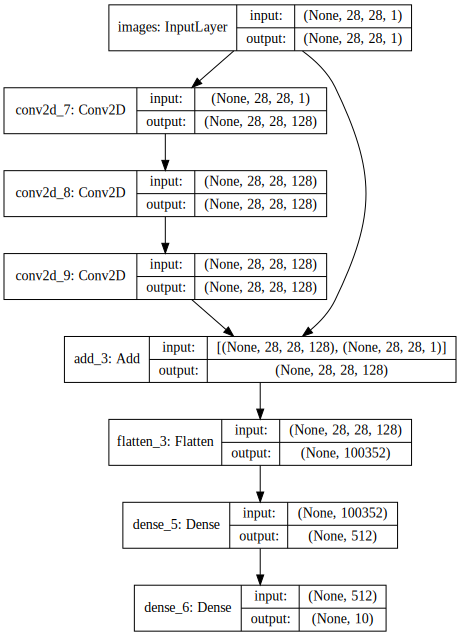

In [0]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

###### ResNET implementation when the feature-map sizes differ

And the following implements a residual connection when the feature-map sizes differ, using a linear residual connection (again, assuming the existence of a 4D input tensor x):

In [0]:
from keras import layers 
from keras.layers import Input

# This example assumes the existence of a 4D input tensor x:
# This returns a typical image tensor like those of MNIST dataset 
x = Input(shape=(28, 28, 1), dtype='float32', name='images')
print("x.shape:",x.shape)

# Applies a transformation to x
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.MaxPooling2D(2, strides=2)(y)

# Uses a 1 × 1 convolution to linearly downsample the original x tensor to the same shape as y
residual = layers.Conv2D(128, 1, strides=2, padding='same')(x)

# Adds the residual tensor back to the output features
output = layers.add([y, residual])

# Adding a classifier on top of the convnet
output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)
model = keras.models.Model(inputs=x, outputs=predictions)

x.shape: (?, 28, 28, 1)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 28, 28, 128)  1280        images[0][0]                     
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 28, 28, 128)  147584      conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 128)  0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

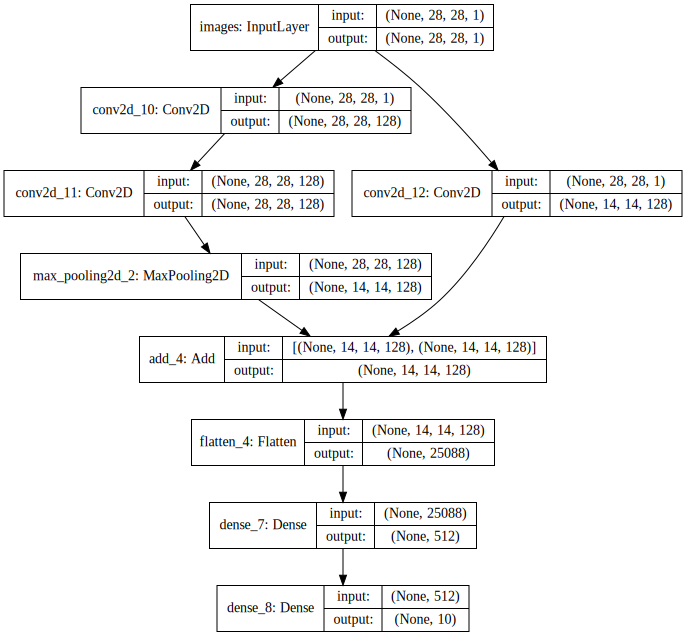

In [0]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

#### Train and Save the ResNet model using  the CIFAR10 data

In [0]:
#法1
import keras
import tempfile
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Add, Concatenate, Lambda
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import Adam
from keras import regularizers
from keras import backend as K
import numpy as np
import tempfile
from keras.datasets import cifar10
from keras import backend as K
from keras import layers
from keras.utils import np_utils

import os

def zeropad(x):
    y = K.zeros_like(x)
    return Concatenate()([x,y])

def residualConvolution(x, num_filter, size, num_layer, reg, padding=False):
    c = x
    #ASSUME THE SIZE OF AXIS -1 DOUBLE
    if padding:
        x = Lambda(zeropad)(x)

    for i in range(num_layer-1):
        c = Conv2D(num_filter, (size, size), padding='same')(c)
        c = Dropout(0.1)(c)
        c = BatchNormalization()(c)
        c = Activation('relu')(c)

    c = Conv2D(num_filter, (size, size), padding='same')(c)
    c = Dropout(0.1)(c)
    c = BatchNormalization()(c)

    # add back residual before non-linearity
    y = Add()([c, x])
    return Activation('relu')(c)


# 19 layers network based on VGG architecture with residual connection
def generateModel(reg, dropout_p, input_shape, num_classes):

    inputs = Input(input_shape)

    # First Block: 1 128 3x3 convolutional filters (strides 2)
    y = Conv2D(128, (3, 3), padding='same' )(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Second Block: 2 128 3x3 convolutional filters with residual connection
    y = residualConvolution(y, num_filter=128, size=3, num_layer=2, reg=reg)

    y = MaxPooling2D()(y)
    y = Dropout(0.25)(y)

    # Third Block: 2 256 3x3 convolutional filters with residual connection
    y = residualConvolution(y, num_filter=256, size=3, num_layer=2, reg=reg, padding=True)

    # Fourth Block: 2 256 3x3 convolutional filters with residual connection
    y = residualConvolution(y, num_filter=256, size=3, num_layer=2, reg=reg)

    y = MaxPooling2D()(y)
    y = Dropout(0.25)(y)

    # Fifth Block: 2 512 3x3 convolutional filters with residual connection
    y = residualConvolution(y, num_filter=512, size=3, num_layer=2, reg=reg, padding=True)

    # Sixth Block: 2 512 3x3 convolutional filters with residual connection
    y = residualConvolution(y, num_filter=512, size=3, num_layer=2, reg=reg)


    y = Flatten()(y)

    for i in range(1):
        y = Dense(512)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Dropout(dropout_p)(y)

    y = Dense(num_classes, activation='softmax')(y)

    


    return y

In [0]:
# 法2
import keras
import tempfile
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Add, Concatenate, Lambda
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import Adam
from keras import regularizers
from keras import backend as K
import numpy as np
import tempfile
from keras.datasets import cifar10
from keras import backend as K
from keras import layers
from keras.utils import np_utils

import os

def zeropad(x):
    y = K.zeros_like(x)
    return Concatenate()([x,y])

def residualConvolution(x, num_filter, size, num_layer, reg, padding=False):
    c = x
    #ASSUME THE SIZE OF AXIS -1 DOUBLE
    if padding:
        x = Lambda(zeropad)(x)

    for i in range(num_layer-1):
        c = Conv2D(num_filter, (size, size), padding='same')(c)
        c = Dropout(0.1)(c)
        c = BatchNormalization()(c)
        c = Activation('relu')(c)

    c = Conv2D(num_filter, (size, size), padding='same')(c)
    c = Dropout(0.1)(c)
    c = BatchNormalization()(c)

    # add back residual before non-linearity
    c = Add()([c, x])
    return Activation('relu')(c)


# 19 layers network based on VGG architecture with residual connection
def generateModel(reg, dropout_p, input_shape, num_classes):

    inputs = Input(input_shape)

    # First Block: 1 128 3x3 convolutional filters (strides 2)
    y = Conv2D(128, (3, 3), padding='same' )(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Second Block: 2 128 3x3 convolutional filters with residual connection
    y = residualConvolution(y, num_filter=128, size=3, num_layer=2, reg=reg)

    y = MaxPooling2D()(y)
    y = Dropout(0.25)(y)

    # Third Block: 2 256 3x3 convolutional filters with residual connection
    y = residualConvolution(y, num_filter=256, size=3, num_layer=2, reg=reg, padding=True)

    # Fourth Block: 2 256 3x3 convolutional filters with residual connection
    y = residualConvolution(y, num_filter=256, size=3, num_layer=2, reg=reg)

    y = MaxPooling2D()(y)
    y = Dropout(0.25)(y)

    # Fifth Block: 2 512 3x3 convolutional filters with residual connection
    y = residualConvolution(y, num_filter=512, size=3, num_layer=2, reg=reg, padding=True)

    # Sixth Block: 2 512 3x3 convolutional filters with residual connection
    y = residualConvolution(y, num_filter=512, size=3, num_layer=2, reg=reg)


    y = Flatten()(y)

    for i in range(1):
        y = Dense(512)(y)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Dropout(dropout_p)(y)

    y = Dense(num_classes, activation='softmax')(y)

    


    return y

In [0]:
reg = 0.001
dropout_p = 0.5
lr = 0.00025
num_classes = 10
epochs = 40

batch_size = 128
buffer_size = 10000

steps_per_epoch = int(np.ceil(50000 / float(batch_size)))  

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255
print(x_train.shape)
input_shape = x_train.shape[1:]
print (input_shape)

y_train = np_utils.to_categorical(y_train, num_classes)



#print("inputs.shape:",inputs.shape)
#print("targets.shape:",targets.shape)

#model_input = layers.Input(tensor=inputs)
x = Input(shape = input_shape, dtype  = 'float32', name = 'images')
model_output = generateModel(reg, dropout_p, input_shape, num_classes)


model = keras.models.Model(inputs = x, outputs = model_output)

model.compile(optimizer=keras.optimizers.Adam(lr = lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )

(50000, 32, 32, 3)
(32, 32, 3)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  3584        images[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 128)  512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 128)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

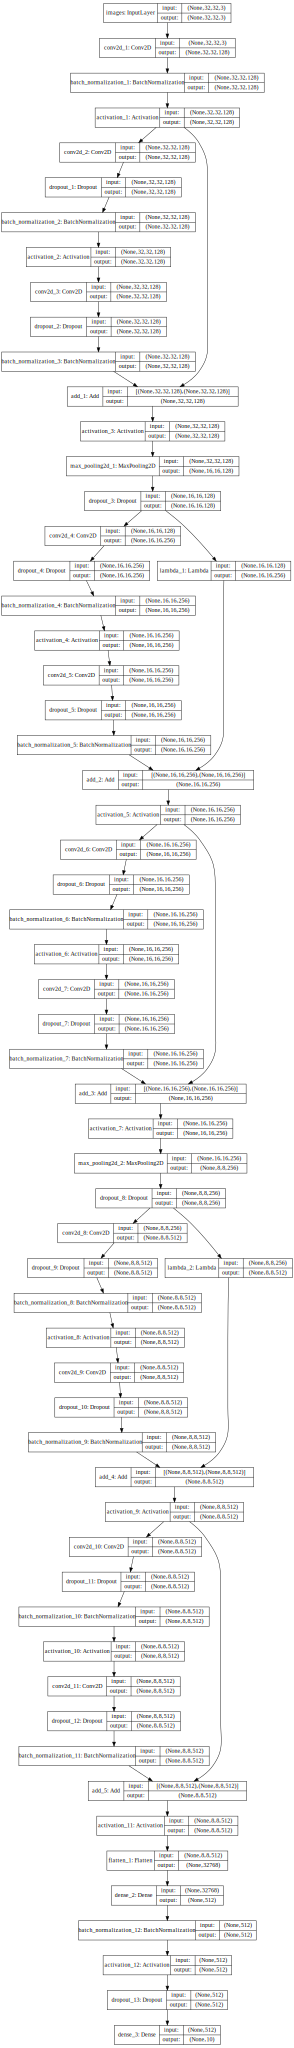

In [0]:
#法2
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


#下載模型的視覺化圖檔
from keras.utils import plot_model
plot_model(model, to_file='model_ResNet.png')
from google.colab import files
files.download('model_ResNet.png')
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
#法2
callbacks_list = [
    # Interrupts training when improvement stops
    keras.callbacks.EarlyStopping(
        # Monitors the model’s validation accuracy
        monitor='val_acc',
        # Interrupts training when accuracy has stopped 
        # improving for more than one epoch (that is, two epochs)
        patience=5,
    ),
    # Saves the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
        # Path to the destination model file
        filepath= os.path.join(tempfile.gettempdir(), 'saved_ResNet_wt.h5'),
        # These two arguments mean you won’t overwrite the model file 
        # unless val_loss has improved, 
        monitor='val_loss',
        # which allows you to keep the best model seen during training
        save_best_only=True,
    )
]

history = model.fit(x_train, y_train, batch_size = 128, validation_split = 0.2, epochs = 40, callbacks = callbacks_list)

Train on 40000 samples, validate on 10000 samples
Epoch 1/40
40000/40000 [==============================] - 149s 4ms/step - loss: 1.5710 - acc: 0.4673 - val_loss: 2.0727 - val_acc: 0.3919
Epoch 2/40
40000/40000 [==============================] - 139s 3ms/step - loss: 1.0149 - acc: 0.6454 - val_loss: 1.2430 - val_acc: 0.5974
Epoch 3/40
40000/40000 [==============================] - 139s 3ms/step - loss: 0.7908 - acc: 0.7215 - val_loss: 1.0706 - val_acc: 0.6603
Epoch 4/40
40000/40000 [==============================] - 139s 3ms/step - loss: 0.6508 - acc: 0.7734 - val_loss: 0.8369 - val_acc: 0.7202
Epoch 5/40
40000/40000 [==============================] - 140s 4ms/step - loss: 0.5568 - acc: 0.8051 - val_loss: 0.6720 - val_acc: 0.7792
Epoch 6/40
40000/40000 [==============================] - 139s 3ms/step - loss: 0.4853 - acc: 0.8324 - val_loss: 0.7054 - val_acc: 0.7758
Epoch 7/40
40000/40000 [==============================] - 140s 4ms/step - loss: 0.4197 - acc: 0.8555 - val_loss: 0.8076 - 

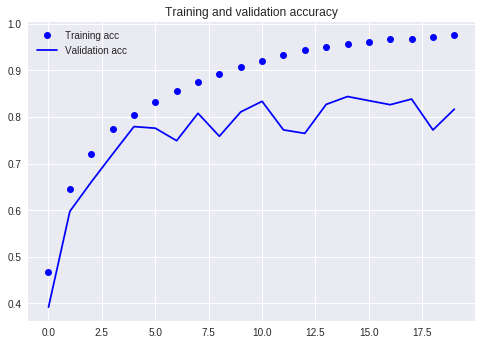

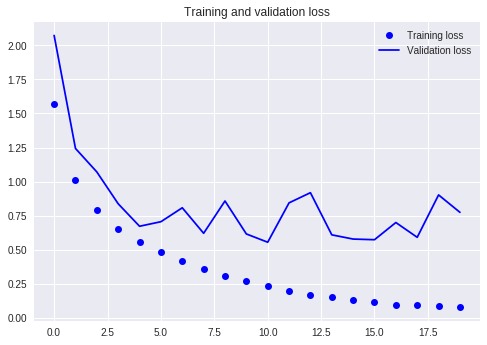

In [0]:
#法2
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
#法2
# 載入weights
weight_path = os.path.join(tempfile.gettempdir(), 'saved_ResNet_wt.h5')
model.load_weights(weight_path)

# Evaluate 
x_test = x_test.astype('float32')
x_test /= 255
y_test = keras.utils.to_categorical(y_test, num_classes)
scores = model.evaluate(x_test, y_test, verbose=1)

10000/10000 [==============================] - 12s 1ms/step


In [0]:
#法2
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.5754121539831162
Test accuracy: 0.8257


In [0]:
! ls -al "/tmp/"

total 321512
drwxrwxrwt 1 root root      4096 Nov 15 08:37 .
drwxr-xr-x 1 root root      4096 Nov 15 04:31 ..
-rw-r--r-- 1 root root 329217080 Nov 15 09:01 saved_ResNet_wt.h5


In [0]:
weight_path

'/tmp/saved_ResNet_wt.h5'

In [0]:
! date '+%A %d %m %Y %X'

Thursday 15 11 2018 09:37:36 AM


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 128)       512       
__________

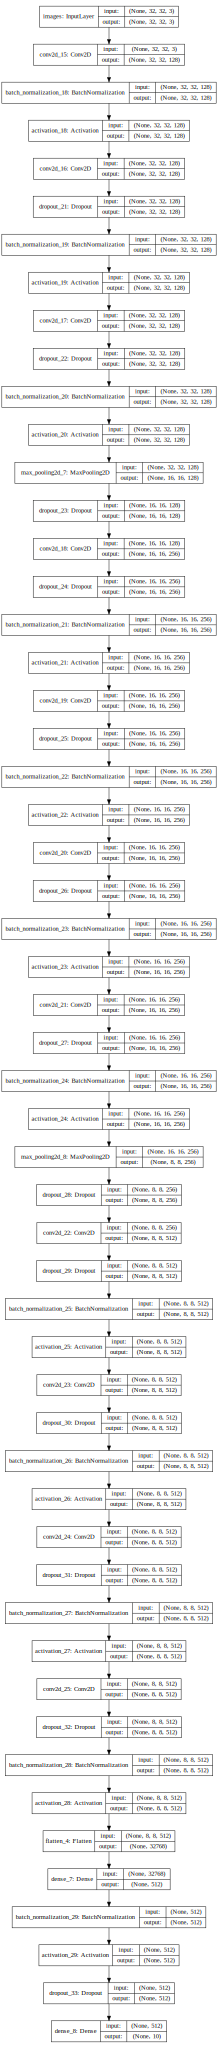

In [0]:
#法1
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


#下載模型的視覺化圖檔
from keras.utils import plot_model
plot_model(model, to_file='model_ResNet.png')
from google.colab import files
files.download('model_ResNet.png')
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
#法1
callbacks_list = [
    # Interrupts training when improvement stops
    keras.callbacks.EarlyStopping(
        # Monitors the model’s validation accuracy
        monitor='val_acc',
        # Interrupts training when accuracy has stopped 
        # improving for more than one epoch (that is, two epochs)
        patience=5,
    ),
    # Saves the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
        # Path to the destination model file
        filepath= os.path.join(tempfile.gettempdir(), 'saved_ResNet_wt.h5'),
        # These two arguments mean you won’t overwrite the model file 
        # unless val_loss has improved, 
        monitor='val_loss',
        # which allows you to keep the best model seen during training
        save_best_only=True,
    )
]

history = model.fit(x_train, y_train, batch_size = 128, validation_split = 0.2, epochs = 40, callbacks = callbacks_list)
          



Train on 40000 samples, validate on 10000 samples
Epoch 1/40
40000/40000 [==============================] - 145s 4ms/step - loss: 1.7281 - acc: 0.4000 - val_loss: 2.3659 - val_acc: 0.3231
Epoch 2/40
40000/40000 [==============================] - 129s 3ms/step - loss: 1.1927 - acc: 0.5826 - val_loss: 1.2764 - val_acc: 0.5719
Epoch 3/40
40000/40000 [==============================] - 129s 3ms/step - loss: 0.9021 - acc: 0.6867 - val_loss: 1.1411 - val_acc: 0.6293
Epoch 4/40
40000/40000 [==============================] - 129s 3ms/step - loss: 0.7311 - acc: 0.7449 - val_loss: 0.8386 - val_acc: 0.7321
Epoch 5/40
40000/40000 [==============================] - 129s 3ms/step - loss: 0.6148 - acc: 0.7828 - val_loss: 0.7884 - val_acc: 0.7549
Epoch 6/40
40000/40000 [==============================] - 129s 3ms/step - loss: 0.5264 - acc: 0.8166 - val_loss: 0.7058 - val_acc: 0.7854
Epoch 7/40
40000/40000 [==============================] - 129s 3ms/step - loss: 0.4577 - acc: 0.8405 - val_loss: 0.7346 - 

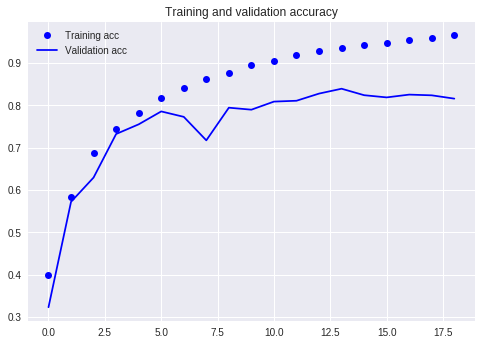

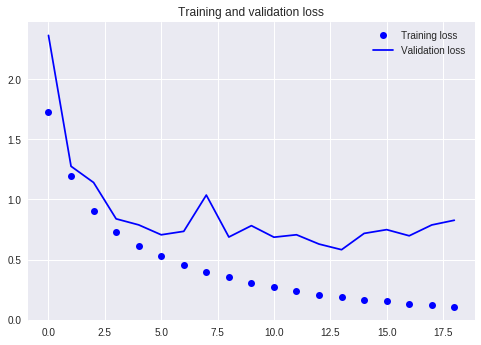

In [0]:
#法1
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
#法1
# 載入weights
weight_path = os.path.join(tempfile.gettempdir(), 'saved_ResNet_wt.h5')
model.load_weights(weight_path)

# Evaluate 
x_test = x_test.astype('float32')
x_test /= 255
y_test = keras.utils.to_categorical(y_test, num_classes)
scores = model.evaluate(x_test, y_test, verbose=1)


10000/10000 [==============================] - 11s 1ms/step


In [0]:
#法1
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.617426807975769
Test accuracy: 0.8281


### 7.1.5. *Layer weights sharing*

One more important feature of the functional API is the ability to reuse a layer instance several times where instead of instantiating a new layer for each call, you reuse the same weights with every call. This allows you to build models that have shared branches—several branches that all share the same knowledge and perform the same operations.  

####  Example - semantic similarity between two sentences

For example, consider a model that attempts to assess the semantic similarity between two sentences. The model has two inputs (the two sentences to compare) and outputs a score between 0 and 1, where 0 means unrelated sentences and 1 means sentences that are either identical or reformulations of each other. Such a model could be useful in many applications, including deduplicating natural-language queries in a dialog system. 

In this setup, the two input sentences are interchangeable, because semantic similarity is a symmetrical relationship: the similarity of A to B is identical to the similarity of B to A. For this reason, it wouldn’t make sense to learn two independent models for processing each input sentence. Rather, you want to process both with a single LSTM layer. The representations of this LSTM layer (its weights) are learned based on both inputs simultaneously. This is what we call a Siamese LSTM model or a shared LSTM.

    Note: Siamese network is a special type of neural network architecture. Instead of learning to classify its
    inputs, the Siamese neural network learns to differentiate between two inputs. It learns the similarity.

Here’s how to implement such a model using layer sharing (layer reuse) in the Keras functional API:

在這裡, 我們將使用真實文本資料來訓練Siamese network

文本資料來自Quora這個問答網站

[https://www.kaggle.com/quora/question-pairs-dataset](https://www.kaggle.com/quora/question-pairs-dataset)

![alt text](https://cdn-images-1.medium.com/max/1000/1*8inl5NyNsmEcqKOPMewgjA.png)


In [0]:
#下載資料集

!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1Ey3PnfSV2SnBHFFiAwjUh2M49WEa9-Al' -O questions.csv.zip

import zipfile
with zipfile.ZipFile(open('questions.csv.zip', 'rb')) as f:
    f.extractall()


will be placed in the single file you specified.

--2018-11-04 10:11:52--  https://docs.google.com/uc?export=download&id=1Ey3PnfSV2SnBHFFiAwjUh2M49WEa9-Al
Resolving docs.google.com (docs.google.com)... 108.177.111.139, 108.177.111.101, 108.177.111.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.111.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2jk9jikrj7fv65v030uitsne2khsqn9e/1541325600000/05881448651423052326/*/1Ey3PnfSV2SnBHFFiAwjUh2M49WEa9-Al?e=download [following]
--2018-11-04 10:11:54--  https://doc-00-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2jk9jikrj7fv65v030uitsne2khsqn9e/1541325600000/05881448651423052326/*/1Ey3PnfSV2SnBHFFiAwjUh2M49WEa9-Al?e=download
Resolving doc-00-ac-docs.googleusercontent.com (doc-00-ac-docs.googleusercontent.com)... 173.194.198.132, 2607:f8b0:4001:c1c::84
Connecti

In [0]:
#下載Ｇoogle word embeedings
!wget --no-check-certificate -r 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz' -O GoogleNews-vectors-negative300.bin.gz


#https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

will be placed in the single file you specified.

--2018-11-04 10:12:09--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.229.141
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.229.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  82.9MB/s    in 19s     

2018-11-04 10:12:29 (82.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]

FINISHED --2018-11-04 10:12:29--
Total wall clock time: 19s
Downloaded: 1 files, 1.5G in 19s (82.0 MB/s)


In [0]:
# 安裝word2vec所需的套件

! pip install gensim

In [0]:
import re

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from gensim.models import KeyedVectors

import gensim

import numpy as np

import itertools

#安裝nltk所需的停用詞集
import nltk
nltk.download('stopwords')




#以下為資料前處理的functions,請大家課後再細看

def text_to_word_list(text):
    # Pre process and convert texts to a list of words
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

#建立word2vec embeedings 

vocabs = {}

def make_w2v_embeddings(df, embedding_dim=300, empty_w2v=False):
    #vocabs = {}
    vocabs_cnt = 0

    vocabs_not_w2v = {}
    vocabs_not_w2v_cnt = 0

    # Stopwords
    stops = set(stopwords.words('english'))

    # Load word2vec
    print("Loading word2vec model(it may takes 2-3 mins) ...")

    if empty_w2v:
        word2vec = EmptyWord2Vec
    else:
        word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
        #若有下載Google的word embeeding（GoogleNews-vectors-negative300.bin.gz）可執行此行
        # word2vec = gensim.models.word2vec.Word2Vec.load("./data/Quora-Question-Pairs.w2v").wv

    for index, row in df.iterrows():
        # Print the number of embedded sentences.
        if index != 0 and index % 1000 == 0:
            print("{:,} sentences embedded.".format(index), flush=True)

        # Iterate through the text of both questions of the row
        for question in ['question1', 'question2']:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):
                # Check for unwanted words
                if word in stops:
                    continue

                # If a word is missing from word2vec model.
                if word not in word2vec.vocab:
                    if word not in vocabs_not_w2v:
                        vocabs_not_w2v_cnt += 1
                        vocabs_not_w2v[word] = 1

                # If you have never seen a word, append it to vocab dictionary.
                if word not in vocabs:
                    vocabs_cnt += 1
                    vocabs[word] = vocabs_cnt
                    q2n.append(vocabs_cnt)
                else:
                    q2n.append(vocabs[word])

            # Append question as number representation
            df.at[index, question + '_n'] = q2n

    embeddings = 1 * np.random.randn(len(vocabs) + 1, embedding_dim)  # This will be the embedding matrix
    embeddings[0] = 0  # So that the padding will be ignored

    # Build the embedding matrix
    for word, index in vocabs.items():
        if word in word2vec.vocab:
            embeddings[index] = word2vec.word_vec(word)
    del word2vec

    return df, embeddings


def split_and_zero_padding(df, max_seq_length):
    # Split to dicts
    X = {'left': df['question1_n'], 'right': df['question2_n']}

    # Zero padding
    for dataset, side in itertools.product([X], ['left', 'right']):
        dataset[side] = pad_sequences(dataset[side], padding='pre', truncating='post', maxlen=max_seq_length)

    return dataset





class EmptyWord2Vec:
    """
    Just for test use.
    """
    vocab = {}
word_vec = {}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
import pandas as pd
TRAIN_CSV = 'questions.csv'

# Load training set
train_df = pd.read_csv(TRAIN_CSV)
for q in ['question1', 'question2']:
    train_df[q + '_n'] = train_df[q]

# Make word2vec embeddings
embedding_dim = 300
max_seq_length = 20

#不使用word2vec訓練好摸word embeedings, 使用隨機初始化的embeedings, 交由神經網路來train其權重
use_w2v = False

train_df, embeddings = make_w2v_embeddings(train_df, embedding_dim=embedding_dim, empty_w2v=not use_w2v)

Loading word2vec model(it may takes 2-3 mins) ...
1,000 sentences embedded.
2,000 sentences embedded.
3,000 sentences embedded.
4,000 sentences embedded.
5,000 sentences embedded.
6,000 sentences embedded.
7,000 sentences embedded.
8,000 sentences embedded.
9,000 sentences embedded.
10,000 sentences embedded.
11,000 sentences embedded.
12,000 sentences embedded.
13,000 sentences embedded.
14,000 sentences embedded.
15,000 sentences embedded.
16,000 sentences embedded.
17,000 sentences embedded.
18,000 sentences embedded.
19,000 sentences embedded.
20,000 sentences embedded.
21,000 sentences embedded.
22,000 sentences embedded.
23,000 sentences embedded.
24,000 sentences embedded.
25,000 sentences embedded.
26,000 sentences embedded.
27,000 sentences embedded.
28,000 sentences embedded.
29,000 sentences embedded.
30,000 sentences embedded.
31,000 sentences embedded.
32,000 sentences embedded.
33,000 sentences embedded.
34,000 sentences embedded.
35,000 sentences embedded.
36,000 sentenc

In [0]:
#embeedings的維度為300
embeddings.shape

(85875, 300)

In [0]:
#觀查其中一個詞的embedding向量內容
embeddings[1]

array([-0.38364957, -0.26879586, -0.06596126, -1.39757429,  0.76987036,
       -1.02234309,  0.94062954, -0.64016138, -1.82078856, -1.00352242,
       -0.26517278,  0.70722258,  0.26891933, -0.61799643, -1.27027618,
       -0.81611625, -1.15383747, -0.47841508, -1.04315984,  1.96259416,
       -0.47600498, -0.30744685,  1.27818641,  0.6605044 , -0.41666049,
        1.01230792,  0.52803812,  0.1990174 , -0.41910872, -1.33454405,
        0.96383357,  0.28256065, -0.27146935,  1.63116663, -0.93793926,
       -1.34437249, -0.68198521,  0.34336885, -1.11959809, -0.81809045,
        0.26940654, -0.5268423 , -0.85947327,  0.67620704, -1.96643059,
        1.15625116,  0.78262689,  1.26832895, -0.72577582, -0.52806436,
       -0.27662911,  0.20934806, -0.18836113, -1.51751348,  0.62678425,
        1.14168914,  0.43046918, -1.00209276,  0.78647026, -0.18222903,
        0.19076548,  1.56551737, -1.23003002, -1.93593086,  0.27761621,
       -0.19357746,  0.49919449,  0.01041363,  0.1477327 ,  0.80

In [0]:
# Split to train validation
from sklearn.model_selection import train_test_split
validation_size = int(len(train_df) * 0.1)
training_size = len(train_df) - validation_size

X = train_df[['question1_n', 'question2_n']]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

X_train = split_and_zero_padding(X_train, max_seq_length)
X_validation = split_and_zero_padding(X_validation, max_seq_length)

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

In [0]:
#觀察一下，經前處理的training資料，詞都已轉成整數數字
train_df.head(100)

,id,qid1,qid2,question1,question2,is_duplicate,question1_n,question2_n
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[1, 1, 2, 3, 4, 5, 6]","[1, 1, 2, 3, 4, 5]"
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[7, 8, 9, 10, 10, 11, 12]","[13, 14, 15, 16, 17, 8, 9, 10, 10, 11, 12, 18]"
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[19, 20, 21, 22, 23, 24]","[21, 20, 25, 26, 27]"
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[28, 29, 30]","[31, 32, 33, 34, 35, 36, 33, 37, 36, 34]"
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[38, 39, 40, 41, 42, 43, 44, 45, 46, 47]","[48, 13, 49, 43, 40]"
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,"[50, 51, 52, 53, 54, 55, 54, 56, 57]","[58, 52, 53, 55, 59, 52, 57]"
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,"[60, 61]","[62, 63, 64, 65, 66, 67, 68]"
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,"[69, 70]","[71, 70]"
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,"[72, 73]","[72, 73]"
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,"[74, 75, 51, 76, 77, 78, 79]","[76, 74, 79, 80, 21]"


In [0]:
train_df.iloc[0]['question1']

'What is the step by step guide to invest in share market in india?'

In [0]:
train_df.iloc[0]['question2']

'What is the step by step guide to invest in share market?'

In [0]:
# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [0]:
X_train['left'][0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  140, 5061,  259, 1072, 4614], dtype=int32)

In [0]:
X_train['right'][0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,  5832,
        2005, 15007], dtype=int32)

In [0]:
from keras import layers
from keras import Input
from keras.models import Model
from keras.layers import Embedding
# Instantiates a single LSTM layer, once
lstm = layers.LSTM(32)

#使用上面處理建好的embeedings來建立embeeding layer


embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=True)

left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')
# Building the left branch of the model: 
# Embedded version of the inputs

encoded_left = embedding_layer(left_input)
left_output = lstm(encoded_left)



# Building the right branch of the model:
# when you call an existing layer instance, you reuse its weights.
# Embedded version of the inputs

encoded_right = embedding_layer(right_input)
right_output = lstm(encoded_right)




# Builds the classifier on top
merged = layers.concatenate([left_output, right_output], axis=-1)
predictions = layers.Dense(1, activation='sigmoid')(merged)

# Instantiating the model
model = Model([left_input, right_input], predictions)

In [0]:
gpus = 1
batch_size = 1024 * gpus
n_epoch = 20
n_hidden = 50

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

from time import time
training_start_time = time()
"""
malstm_trained = model.fit([X_train['left'].reshape(X_train['left'].shape[0],1,max_seq_length), X_train['right'].reshape(X_train['right'].shape[0],1,max_seq_length)], Y_train,
                           batch_size=batch_size, epochs=n_epoch,
                           validation_data=([X_validation['left'].reshape(X_validation['left'].shape[0],1,max_seq_length), X_validation['right'].reshape(X_validation['right'].shape[0],1,max_seq_length)], Y_validation))
"""
malstm_trained = model.fit([X_train['left'], X_train['right']], Y_train,
                           batch_size=batch_size, epochs=n_epoch,
                           validation_data=([X_validation['left'], X_validation['right']], Y_validation))

training_end_time = time()

Train on 363916 samples, validate on 40435 samples
Epoch 1/20
363916/363916 [==============================] - 60s 165us/step - loss: 0.5485 - acc: 0.7235 - val_loss: 0.5210 - val_acc: 0.7402
Epoch 2/20
363916/363916 [==============================] - 57s 157us/step - loss: 0.4862 - acc: 0.7672 - val_loss: 0.4970 - val_acc: 0.7621
Epoch 3/20
363916/363916 [==============================] - 56s 154us/step - loss: 0.4556 - acc: 0.7862 - val_loss: 0.4924 - val_acc: 0.7654
Epoch 4/20
363916/363916 [==============================] - 55s 152us/step - loss: 0.4306 - acc: 0.8013 - val_loss: 0.4914 - val_acc: 0.7661
Epoch 5/20
363916/363916 [==============================] - 55s 151us/step - loss: 0.4082 - acc: 0.8138 - val_loss: 0.4911 - val_acc: 0.7692
Epoch 6/20
363916/363916 [==============================] - 55s 151us/step - loss: 0.3878 - acc: 0.8252 - val_loss: 0.4936 - val_acc: 0.7746
Epoch 7/20
363916/363916 [==============================] - 56s 153us/step - loss: 0.3684 - acc: 0.8356

In [0]:
model.save("Siamese_model.h5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 300)      25762500    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           42624       embedding_1[0][0]                
          

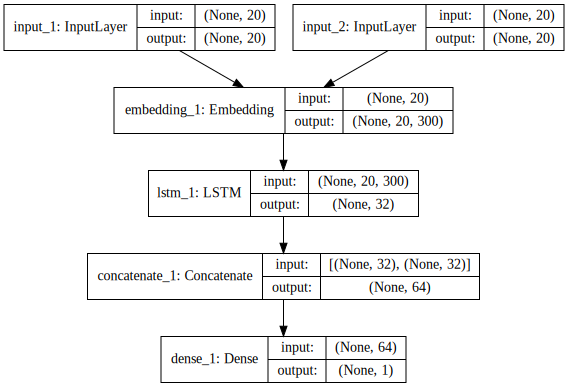

In [0]:
from keras.models import load_model
model = load_model("Siamese_model.h5")
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
print (training_start_time, training_end_time)

1541327867.2606907 1541328993.6600316


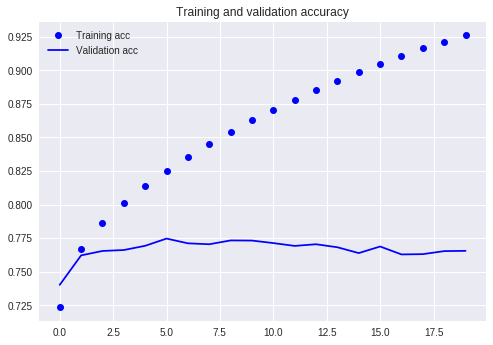

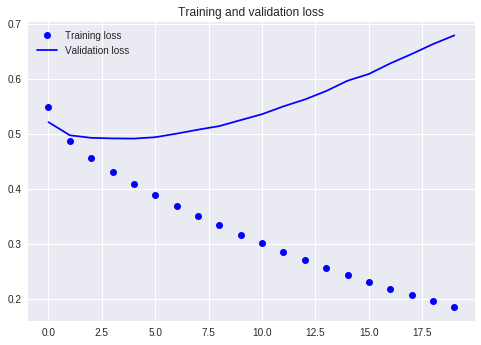

In [0]:
import matplotlib.pyplot as plt

acc = malstm_trained.history['acc']
val_acc = malstm_trained.history['val_acc']
loss = malstm_trained.history['loss']
val_loss = malstm_trained.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 使用word2vec

In [0]:
# train一版: embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

use_w2v = True

train_df, embeddings = make_w2v_embeddings(train_df, embedding_dim=embedding_dim, empty_w2v=not use_w2v)




from keras import layers
from keras import Input
from keras.models import Model
from keras.layers import Embedding
# Instantiates a single LSTM layer, once
lstm = layers.LSTM(32)

#使用上面處理建好的embeedings來建立embeeding layer
#trainable設為False
embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)
# Building the left branch of the model: 
# inputs are variable-length sequences of vectors of size 128.
#left_input = Input(shape=(None, max_seq_length))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')


# Embedded version of the inputs
encoded_left = embedding_layer(left_input)


left_output = lstm(encoded_left)



# Building the right branch of the model:
# when you call an existing layer instance, you reuse its weights.
#right_input = Input(shape=(None, max_seq_length))

# Embedded version of the inputs
encoded_right = embedding_layer(right_input)

right_output = lstm(encoded_right)




# Builds the classifier on top
merged = layers.concatenate([left_output, right_output], axis=-1)
predictions = layers.Dense(1, activation='sigmoid')(merged)

# Instantiating the model
model = Model([left_input, right_input], predictions)

gpus = 1
batch_size = 1024 * gpus
n_epoch = 20
n_hidden = 50

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])



Loading word2vec model(it may takes 2-3 mins) ...
1,000 sentences embedded.
2,000 sentences embedded.
3,000 sentences embedded.
4,000 sentences embedded.
5,000 sentences embedded.
6,000 sentences embedded.
7,000 sentences embedded.
8,000 sentences embedded.
9,000 sentences embedded.
10,000 sentences embedded.
11,000 sentences embedded.
12,000 sentences embedded.
13,000 sentences embedded.
14,000 sentences embedded.
15,000 sentences embedded.
16,000 sentences embedded.
17,000 sentences embedded.
18,000 sentences embedded.
19,000 sentences embedded.
20,000 sentences embedded.
21,000 sentences embedded.
22,000 sentences embedded.
23,000 sentences embedded.
24,000 sentences embedded.
25,000 sentences embedded.
26,000 sentences embedded.
27,000 sentences embedded.
28,000 sentences embedded.
29,000 sentences embedded.
30,000 sentences embedded.
31,000 sentences embedded.
32,000 sentences embedded.
33,000 sentences embedded.
34,000 sentences embedded.
35,000 sentences embedded.
36,000 sentenc

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 300)      25762500    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 32)           42624       embedding_2[0][0]                
          

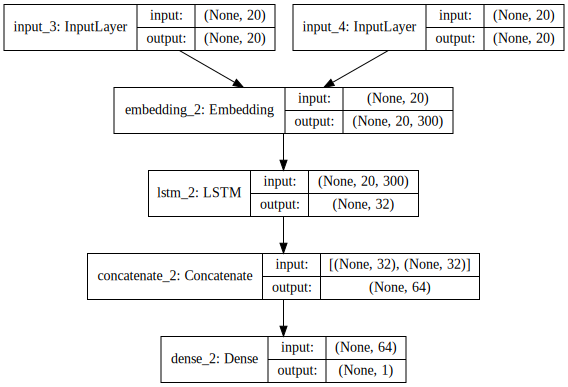

In [0]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
from time import time
training_start_time = time()

malstm_trained = model.fit([X_train['left'], X_train['right']], Y_train,
                           batch_size=batch_size, epochs=n_epoch,
                           validation_data=([X_validation['left'], X_validation['right']], Y_validation))

training_end_time = time()

Train on 363916 samples, validate on 40435 samples
Epoch 1/20
363916/363916 [==============================] - 47s 128us/step - loss: 0.5727 - acc: 0.7008 - val_loss: 0.5532 - val_acc: 0.7178
Epoch 2/20
363916/363916 [==============================] - 44s 121us/step - loss: 0.5417 - acc: 0.7281 - val_loss: 0.5439 - val_acc: 0.7221
Epoch 3/20
363916/363916 [==============================] - 44s 120us/step - loss: 0.5272 - acc: 0.7371 - val_loss: 0.5335 - val_acc: 0.7317
Epoch 4/20
363916/363916 [==============================] - 44s 120us/step - loss: 0.5164 - acc: 0.7447 - val_loss: 0.5249 - val_acc: 0.7389
Epoch 5/20
363916/363916 [==============================] - 45s 124us/step - loss: 0.5082 - acc: 0.7495 - val_loss: 0.5135 - val_acc: 0.7484
Epoch 6/20
363916/363916 [==============================] - 44s 122us/step - loss: 0.5006 - acc: 0.7541 - val_loss: 0.5083 - val_acc: 0.7521
Epoch 7/20
363916/363916 [==============================] - 44s 122us/step - loss: 0.4944 - acc: 0.7580

In [0]:
model.save("Siamese_emb_not_trainable_model.h5")

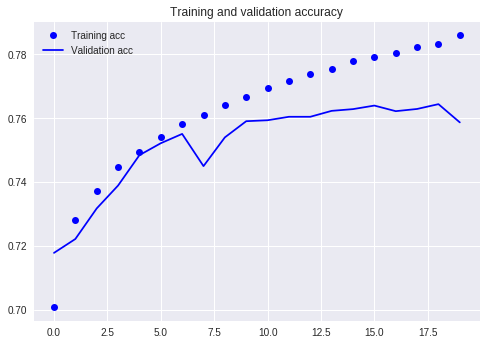

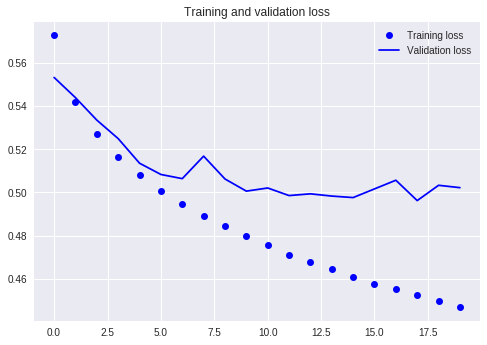

In [0]:
import matplotlib.pyplot as plt

acc = malstm_trained.history['acc']
val_acc = malstm_trained.history['val_acc']
loss = malstm_trained.history['loss']
val_loss = malstm_trained.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
! ls -al '/content/'

total 16
drwxr-xr-x 4 root root 4096 Nov  1 16:42 .
drwxr-xr-x 1 root root 4096 Nov  5 13:25 ..
drwxr-xr-x 4 root root 4096 Nov  1 16:29 .config
drwxr-xr-x 2 root root 4096 Nov  1 16:42 sample_data


In [0]:
from keras.models import load_model
model = load_model("Siamese_emb_not_trainable_model.h5")

In [0]:
predict_results = model.predict([X_validation['left'][0:20],X_validation['right'][0:20]])

In [0]:
import numpy
numpy.round(predict_results,2)

array([[0.22],
       [0.57],
       [0.66],
       [0.06],
       [0.11],
       [0.51],
       [0.61],
       [0.19],
       [0.  ],
       [0.94],
       [0.1 ],
       [0.21],
       [0.62],
       [0.15],
       [0.31],
       [0.68],
       [0.45],
       [0.99],
       [0.11],
       [0.55]], dtype=float32)

In [0]:
#觀察測試集中相似度高的 question pair-> 第9筆,相似度為0.94
X_validation['left'][9]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  151,  200,  166, 8054], dtype=int32)

In [0]:
X_validation['right'][9]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,   657,
         166, 14025], dtype=int32)

In [0]:
inv_vocabs = {}
for key in vocabs:
  inv_vocabs[vocabs[key]] = key

In [0]:
#印出question的文字(pair的左邊)
for x in X_validation['left'][9]:
  if x != 0:
    print (inv_vocabs[x])


best
way
avoid
procrastination


In [0]:
#印出question的文字(pair的右邊)
for x in X_validation['right'][9]:
  if x != 0:
    print (inv_vocabs[x])


could
avoid
laziness


In [0]:
#使用亂數模擬資料
import numpy as np

num_samples = 100
num_symbols = 10

TRACE = True

left_data = np.random.randint(0,num_symbols, size=(num_samples,1,128))
if TRACE:
    print(type(left_data))
    print(left_data.shape)
    print(left_data)
    print('-'*50)

right_data = np.random.randint(0,num_symbols, size=(num_samples,1,128))
if TRACE:
    print(type(right_data))
    print(right_data.shape)
    print(right_data)
    print('-'*50)

matching_list = [np.random.randint(0,num_symbols) for _ in range(num_samples)]
targets = np.array(matching_list)
if TRACE:
    print(type(targets))
    print(targets.shape)
    print(targets)
    print('-'*50)



<class 'numpy.ndarray'>
(100, 1, 128)
[[[4 1 1 ... 4 4 7]]

 [[8 7 6 ... 9 8 7]]

 [[6 6 3 ... 7 4 2]]

 ...

 [[7 7 5 ... 8 0 6]]

 [[7 9 7 ... 0 9 5]]

 [[6 7 1 ... 2 6 7]]]
--------------------------------------------------
<class 'numpy.ndarray'>
(100, 1, 128)
[[[2 3 3 ... 5 3 0]]

 [[2 1 6 ... 0 7 8]]

 [[8 9 3 ... 6 0 4]]

 ...

 [[4 9 7 ... 7 9 5]]

 [[7 3 0 ... 7 8 3]]

 [[9 4 8 ... 4 3 4]]]
--------------------------------------------------
<class 'numpy.ndarray'>
(100,)
[0 8 3 4 5 0 1 0 3 1 1 4 7 4 6 7 4 0 8 0 2 6 5 3 2 3 5 7 5 7 7 4 1 1 0 8 1
 9 5 2 8 9 1 5 3 0 0 7 9 4 2 5 4 3 6 0 4 0 0 9 4 8 7 7 6 8 5 2 5 0 5 8 0 6
 3 1 7 9 8 4 0 9 5 3 9 2 4 4 5 2 0 0 4 6 2 3 5 9 7 7]
--------------------------------------------------


In [0]:
#書上的範例程式, 並未使用Embedding layer
from keras import layers
from keras import Input
from keras.models import Model

# Instantiates a single LSTM layer, once
lstm = layers.LSTM(32)

# Building the left branch of the model: 
# inputs are variable-length sequences of vectors of size 128.
left_input = Input(shape=(None, 128))
left_output = lstm(left_input)

# Building the right branch of the model:
# when you call an existing layer instance, you reuse its weights.
right_input = Input(shape=(None, 128))
right_output = lstm(right_input)

# Builds the classifier on top
merged = layers.concatenate([left_output, right_output], axis=-1)
predictions = layers.Dense(1, activation='sigmoid')(merged)

# Instantiating the model
model = Model([left_input, right_input], predictions)

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           20608       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 64)           0           lstm_1[0][0]                     
          

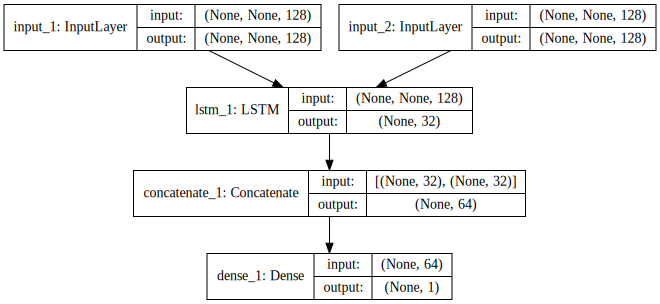

In [0]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [0]:
# 使用模擬資料進行training
# We must compile a model before training/testing.
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

# Training the model: when you train such a model,
# the weights of the LSTM layer are updated based on both inputs.
model.fit([left_data, right_data],targets)

Epoch 1/1
100/100 [==============================] - 3s 31ms/step - loss: -3.0247 - acc: 0.0900


### 7.1.6. Models as layers

Importantly, in the functional API, models can be used as you’d use layers—effectively, you can think of a model as a “bigger layer.” This is true of both the Sequential and Model classes. This means you can call a model on an input tensor and retrieve an output tensor: 

    y = model(x)

If the model has multiple input tensors and multiple output tensors, it should be called with a list of tensors: 

    y1, y2 = model([x1, x2])

When you call a model instance, you’re reusing the weights of the model—exactly like what happens when you call a layer instance. Calling an instance, whether it’s a layer instance or a model instance, will always reuse the existing learned representations of the instance—which is intuitive.

In [0]:
from keras import layers
from keras import applications 
from keras import Input

nbr_classes = 10

# The base image-processing model is the Xception network (convolutional base only).
xception_base = applications.Xception(weights=None,include_top=False)

# The inputs are 250 × 250 RGB images.
left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))

left_features = xception_base(left_input)
# right_input = xception_base(right_input)
right_features = xception_base(right_input)

merged_features = layers.concatenate([left_features, right_features], axis=-1)

predictions = layers.Dense(nbr_classes, activation='softmax')(merged_features)

# Instantiating the model
model = Model([left_input, right_input], predictions)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
xception (Model)                multiple             20861480    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 8, 8, 4096)   0           xception[1][0]                   
          

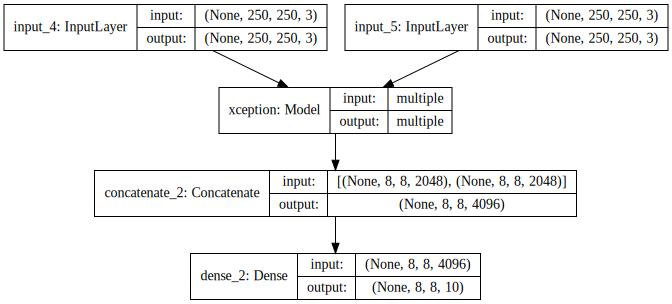

In [0]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))